In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

TOLERANCE = 10 ** -1

## Funkcje pomocnicze

In [2]:

def plotPoints(points):
    return [points[i][0] for i in range(len(points))], [points[i][1] for i in range(len(points))]


def distance(a, b):
    return math.sqrt(((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2))


def det3x3(a, b, c):
    global epsilon
    matrix = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    det = matrix[0][0] * matrix[1][1] * matrix[2][2] + matrix[1][0] * matrix[2][1] * matrix[0][2] + matrix[2][0] * \
          matrix[0][1] * matrix[1][2] - (
                  matrix[0][2] * matrix[1][1] * matrix[2][0] + matrix[0][1] * matrix[1][0] * matrix[2][2] +
                  matrix[0][0] * matrix[1][2] * matrix[2][1])
    return det

def Intersection(l1, l2):
    divider = ((l1[0][0] - l1[1][0]) * (l2[0][1] - l2[1][1]) - (l1[0][1] - l1[1][1]) * (l2[0][0] - l2[1][0]))
    t = ((l1[0][0] - l2[0][0]) * (l2[0][1] - l2[1][1]) - (l1[0][1] - l2[0][1]) * (l2[0][0] - l2[1][0])) / divider
    u = ((l1[0][0] - l2[0][0]) * (l1[0][1] - l1[1][1]) - (l1[0][1] - l2[0][1]) * (l1[0][0] - l1[1][0])) / divider
    if 0 <= t <= 1 and 0 <= u <= 1:
        return (l1[0][0] + t * (l1[1][0] - l1[0][0]), l1[0][1] + t * (l1[1][1] - l1[0][1]))
    else:
        return (False, False)

def merge(list1, list2,key = lambda x: x):
    i = 0
    j = 0
    list_m =[]

    while i < len(list1) and j < len(list2):
        if key(list1[i]) >= key(list2[j]):
            list_m.append(list1[i])
            i += 1
        else:
            list_m.append(list2[j])
            j += 1

    if i <= len(list1) - 1:
        list_m.extend(list1[i:])
    elif j <= len(list2) - 1:
        list_m.extend(list2[j:])
    return list_m

## Interval Tree

In [3]:
class Node:
    def __init__(self, leftEdge, rightEdge):
        self.leftEdge = leftEdge
        self.rightEdge = rightEdge
        self.helper = None
        self.left = None
        self.right = None
        self.parent = None

class BinarySearchTree:

    def __init__(self, points):
        self.root = None
        self.broom = None
        self.points = points
        self.key = lambda x: Intersection(self.broom, (self.points[x[0]], self.points[x[1]]))[0]

    def insert(self, node, value):
        if self.root is None:
            self.root = node
            return
        curr = self.root
        while True:
            if value < self.key(curr.leftEdge):
                if curr.left is None:
                    curr.left = node
                    node.parent = curr
                    break
                curr = curr.left
            else:
                if curr.right is None:
                    curr.right = node
                    node.parent = curr
                    break
                curr = curr.right
    def findEv(self,value):
        curr = self.root
        while True:
            if value < self.key(curr.leftEdge):
                curr = curr.left
            else:
                if curr.right is None:
                    return curr
                elif value < self.key(curr.right.leftEdge):
                    return curr
                else:
                    curr = curr.right
    def delete(self, node):
        # Case 1: The node has no children
        if node.left is None and node.right is None:
            if node.parent is not None:
                if node.parent.left == node:
                    node.parent.left = None
                else:
                    node.parent.right = None
            else:
                self.root = None
        # Case 2: The node has one child
        elif node.left is None or node.right is None:
            child = node.left or node.right
            if node.parent is not None:
                if node.parent.left == node:
                    node.parent.left = child
                else:
                    node.parent.right = child
            else:

                self.root = child
            child.parent = node.parent
        # Case 3: The node has two children
        else:
            # Find the next node and its parent
            next_node = self.findNext(node)
            next_parent = next_node.parent
            # Replace the node's value with the next node's value
            node.leftEdge = next_node.leftEdge
            node.rightEdge = next_node.rightEdge
            node.helper = next_node.helper
            # Disconnect the next node from the tree
            if next_parent.left == next_node:
                next_parent.left = next_node.right
            else:
                next_parent.right = next_node.right
            if next_node.right is not None:
                next_node.right.parent = next_parent
                
    def findNext(self, node):
        if node.right is not None:
            curr = node.right
            while curr.left is not None:
                curr = curr.left
            return curr
        curr = node
        while curr.parent is not None and curr.parent.left != curr:
            curr = curr.parent
        return curr.parent
    





## Podział na wielokąty monotoniczne

In [4]:
def assignVertices(points):
    # 0 - początkowy
    # 1 - końcowy
    # 2 - łączący
    # 3 - dzielący
    # 4 - prawidłowy
    verticesTypes = {}
    for i in range(len(points)):
        det = det3x3(points[i - 1], points[i], points[(i + 1) % len(points)])
        if points[i][1] > points[i - 1][1] and points[i][1] > points[(i + 1) % len(points)][1]:
            if det > 0:
                verticesTypes[i] = 0
            elif det < 0:
                verticesTypes[i] = 3
        elif points[i][1] < points[i - 1][1] and points[i][1] < points[(i + 1) % len(points)][1]:
            if det > 0:
                verticesTypes[i] = 1
            elif det < 0:
                verticesTypes[i] = 2
        else:
            verticesTypes[i] = 4
    return verticesTypes


def findDiagonals(points):
    verticesTypes = assignVertices(points)
    ax.plot(*plotPoints(points + [points[0]]), marker='o', color='black')
    colors = ['green', 'red', 'blue', 'grey', 'brown']
    for i in range(len(points)):
        ax.plot(points[i][0], points[i][1], marker='o', color=colors[verticesTypes[i]])

    sortedIndexes = [i for i in range(len(points))]
    maxY = max(sortedIndexes, key=lambda x: points[x][1])
    minY = min(sortedIndexes, key=lambda x: points[x][1])
    
    rightChain = []
    leftChain = []
    i = maxY
    while i != minY:
        rightChain.append(i)
        i = (i - 1) % len(points)
    i = maxY
    while i != minY:     
        i = (i + 1) % len(points)
        leftChain.append(i)
    sortedIndexes = merge(leftChain, rightChain,key=lambda x:points[x][1])  #O(N)
    
    diagonals = []
    bst = BinarySearchTree(points)
    sortedIndexes = sorted([i for i in range(len(points))], key=lambda x: points[x][1], reverse=True)  #do naprawy
    pointersToBST = [[None for _ in range(len(points))] for _ in range(len(points))]
    for i in sortedIndexes:
        print(i)
        broom = ((10, points[i][1]), (0, points[i][1]))
        #plt.plot(*plotPoints(broom), color = 'red')
        if verticesTypes[i] == 0:  # 0 - początkowy
            node = Node(((i + 1) % len(points), i), (i, (i - 1) % len(points)))
            bst.broom = broom
            bst.insert(node, points[i][0])
            pointersToBST[i][(i + 1) % len(points)] = node
            pointersToBST[(i + 1) % len(points)][i] = node
            pointersToBST[i][(i - 1) % len(points)] = node
            pointersToBST[(i - 1) % len(points)][i] = node
            node.helper = i
        elif verticesTypes[i] == 1:  # 1 - końcowy
            node = pointersToBST[i][(i - 1) % len(points)]
            if verticesTypes[node.helper] == 2:
                diagonals.append((i, node.helper))
            bst.delete(node)
            pointersToBST[i][(i - 1) % len(points)] = None
            pointersToBST[(i - 1) % len(points)][i] = None
            pointersToBST[i][(i + 1) % len(points)] = None
            pointersToBST[(i + 1) % len(points)][i] = None
        elif verticesTypes[i] == 2:  # 2 - łączący
            node1 = pointersToBST[i][(i-1)%len(points)]
            if verticesTypes[node1.helper] ==2:
                diagonals.append((i,node1.helper))
            pointersToBST[i][(i - 1) % len(points)] = None
            pointersToBST[(i - 1) % len(points)][i] = None
            #node2 = bst.findEv(points[i][0]) 
            node2 = pointersToBST[i][(i+1)%len(points)]
            if verticesTypes[node2.helper] ==2:
                diagonals.append((i,node2.helper))
            node2.helper = i
            pointersToBST[node2.rightEdge[0]][node2.rightEdge[1]] = None
            pointersToBST[node2.rightEdge[1]][node2.rightEdge[0]] = None
            node2.rightEdge = node1.rightEdge
            pointersToBST[node2.rightEdge[0]][node2.rightEdge[1]] = node2
            pointersToBST[node2.rightEdge[1]][node2.rightEdge[0]] = node2
            bst.delete(node1)
        elif verticesTypes[i] == 3:  # 3 - dzielący
            bst.broom = broom
            node = bst.findEv(points[i][0])
            diagonals.append((i,node.helper))
            node.helper = i
            newNode = Node((i,(i+1)%len(points)),node.rightEdge)
            newNode.helper = i
            node.rightEdge = (i,(i-1)%len(points))
            bst.insert(newNode,points[i][0])
            pointersToBST[i][(i+1)%len(points)] = newNode
            pointersToBST[(i+1)%len(points)][i] = newNode
            pointersToBST[newNode.rightEdge[0]][newNode.rightEdge[1]] = newNode
            pointersToBST[newNode.rightEdge[1]][newNode.rightEdge[0]] = newNode
            pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = node
            pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = node
        elif verticesTypes[i] == 4:  # 4 - prawidłowy
            if points[i][1] < points[(i-1)%len(points)][1]:
                node = pointersToBST[i][(i-1)%len(points)]
                if verticesTypes[node.helper] == 2:
                    diagonals.append((i,node.helper))
                node.helper = i
                pointersToBST[node.leftEdge[0]][node.leftEdge[1]] = None
                pointersToBST[node.leftEdge[1]][node.leftEdge[0]] = None
                node.leftEdge = (i,(i+1)%len(points))
                pointersToBST[node.leftEdge[0]][node.leftEdge[1]] = node
                pointersToBST[node.leftEdge[1]][node.leftEdge[0]] = node
            else:
                node = pointersToBST[i][(i+1)%len(points)] # albo bst.findEv(points[i][0])
                if verticesTypes[node.helper] == 2:
                    diagonals.append((i,node.helper))
                node.helper = i
                pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = None
                pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = None
                node.rightEdge = (i,(i-1)%len(points))
                pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = node
                pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = node
        if len(diagonals) > 0:
            plt.plot((points[diagonals[-1][0]][0], points[diagonals[-1][1]][0]), (points[diagonals[-1][0]][1], points[diagonals[-1][1]][1]),
                     color='slategrey')
        fig.canvas.draw()

    return diagonals


def makeMonotone(points, diagonals):
    polygons = [[i for i in range(len(points))]]
    for diagonal in diagonals:
        for j, polygon in enumerate(polygons):
            if diagonal[0] not in polygon or diagonal[1] not in polygon:
                continue
            i = polygon.index(diagonal[0])
            subPoly1 = []
            subPoly2 = []
            while polygon[i] != diagonal[1]:
                subPoly1.append(polygon[i])
                i = (i + 1) % len(polygon)
            subPoly1.append(polygon[i])
            while polygon[i] != diagonal[0]:
                subPoly2.append(polygon[i])
                i = (i + 1) % len(polygon)
            subPoly2.append(polygon[i])
            polygons[j] = subPoly1
            polygons.append(subPoly2)
            break
    return [[points[i] for i in subPoly] for subPoly in polygons]  #%%




## Triangulacja wielkoąta y-monotonicznego

In [5]:
def triangulate(points):
    def nextToEachOther(a, b):
        nonlocal points
        return (abs(a - b) == 1 or {a, b} == {0, len(points) - 1})

    epsilon = 10 ** -10
    sortedIndexes = [i for i in range(len(points))]
    maxY = max(sortedIndexes, key=lambda x: points[x][1])
    minY = min(sortedIndexes, key=lambda x: points[x][1])

    stack = []
    diagonals = []

    rightChain = []
    leftChain = []
    i = maxY
    while i != minY:
        rightChain.append(i)
        i = (i - 1) % len(points)
    i = maxY
    while i != minY:     
        i = (i + 1) % len(points)
        leftChain.append(i)
    sortedIndexes = merge(leftChain, rightChain,key=lambda x:points[x][1])  #O(N)

    stack.append(sortedIndexes[0])
    stack.append(sortedIndexes[1])
    for i in sortedIndexes[2:]:
        if {i, stack[-1]}.issubset(leftChain):
            stack.append(i)
            while len(stack) >= 3 and det3x3(points[stack[-3]], points[stack[-2]], points[stack[-1]]) > epsilon:
                if not nextToEachOther(stack[-3], stack[-1]): diagonals.append((stack[-3], stack[-1]))
                stack.pop(-2)
        elif {i, stack[-1]}.issubset(rightChain):
            stack.append(i)
            while len(stack) >= 3 and det3x3(points[stack[-3]], points[stack[-2]], points[stack[-1]]) < -epsilon:
                if not nextToEachOther(stack[-3], stack[-1]): diagonals.append((stack[-3], stack[-1]))
                stack.pop(-2)
        else:
            stack.pop(0)
            while len(stack) >= 2:
                if not nextToEachOther(stack[0], i):  diagonals.append((stack[0], i))
                stack.pop(0)
            if not nextToEachOther(stack[0], i):  diagonals.append((stack[0], i))
            stack.append(i)

        plt.plot(*plotPoints(points + [points[0]]), color='royalblue', marker='o')
        for j in stack:
            plt.plot(points[j][0], points[j][1], color='green', marker='o')
        plt.plot(points[i][0], points[i][1], color='red', marker='o')
        fig.canvas.draw()
        time.sleep(0.2)
        for diagonal in diagonals:
            plt.plot((points[diagonal[0]][0], points[diagonal[1]][0]), (points[diagonal[0]][1], points[diagonal[1]][1]),
                     color='slategrey')
            fig.canvas.draw()
            time.sleep(0.2)
    plt.plot(*plotPoints(points + [points[0]]), color='royalblue', marker='o')
    fig.canvas.draw()

    return diagonals





## Triangulacja Delaunaya 

In [6]:
def orientation(a,b,c):
    return (b.x - a.x)*(c.y - a.y)-(c.x - a.x)*(b.y - a.y) > 0;
class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.triangles = []
    def __repr__(self):
        return "( " + str(self.x) + ", " + str(self.y) + " )"
    def cross(self,point):
        return self.x * point.y - point.x * self.y
    def add(self,triangle):
        self.triangles.append(triangle)
    def remove(self,triangle):
        self.triangles.remove(triangle)
class Edge:
    def __init__(self,pt1,pt2):
        self.pt1 = pt1
        self.pt2 = pt2
class Triangle:
    def __init__(self,pt1,pt2,pt3):
        self.pt1 = pt1
        self.pt2 = pt2
        self.pt3 = pt3
        self.edges = [Edge(pt1,pt2),Edge(pt2,pt3),Edge(pt3,pt1)]
        self.pt1.add(self)
        self.pt2.add(self)
        self.pt3.add(self)
    def in_circumcircle(self, point):
       
        a = Point(self.pt1.x - point.x,self.pt1.y - point.y)
        b = Point(self.pt2.x - point.x,self.pt2.y - point.y)
        c = Point(self.pt3.x - point.x,self.pt3.y - point.y)
        det = (a.x**2 + a.y**2) * b.cross(c) - (b.x**2 + b.y**2) * a.cross(c) + (c.x**2 + c.y**2) * a.cross(b)
        if orientation(self.pt1,self.pt2,self.pt3):
            return det > 0
        else:
            return det < 0
    def has_vertex(self,vertex):
        if self.pt1 == vertex or self.pt2 == vertex or self.pt3 == vertex:
            return True
        return False
    def get_outer_edge(self,point):
        for e in self.edges:
            if e.pt1 != point and e.pt2 !=point:
                return e
    def get_outer_point(self,pt1,pt2):
        if(pt1 != self.pt1 and pt2 != self.pt1):
            return self.pt1
        if(pt1 != self.pt2 and pt2 != self.pt2):
            return self.pt2
        if(pt1 != self.pt3 and pt2 != self.pt3):
            return self.pt3
def supertriangle(point_list):
    big = max(max(abs(point.x), abs(point.y)) for point in point_list)
    m = 4
    p1 = Point(m * big, 0)
    p2 = Point(0, m * big)
    p3 = Point(-m * big, -m * big)
    return Triangle(p1,p2,p3)

def det(a,b,c):
    deta = a.x*b.y + b.x*c.y + a.y*c.x
    detb = c.x*b.y + c.y*a.x + b.x*a.y
    det = deta-detb
    return det

def orient(a, b, c, epsilon=10 ** (-14)):
    deter = det(a,b,c)
    if deter > epsilon:
        return 1
    elif deter < -epsilon:
        return -1
    return 0
def doIntersect(p1,q1,p2,q2):
    
    o1 = orient(p1, q1, p2)
    o2 = orient(p1, q1, q2)
    o3 = orient(p2, q2, p1)
    o4 = orient(p2, q2, q1)

    if ((o1 != o2) and (o3 != o4)):
        return True

    return False  
def shared_edge(edge1,edge2):
    if edge1.pt1 == edge2.pt1 and edge1.pt2 == edge2.pt2 or edge1.pt1 == edge2.pt2 and edge1.pt2 == edge2.pt1:
        return True
    return False
def run_plot_points(T,c):
    for t in T:
        hx = []
        hy = []
        hx.append(t.pt1.x)
        hx.append(t.pt2.x)
        hx.append(t.pt3.x)
        hx.append(t.pt1.x)
        hy.append(t.pt1.y)
        hy.append(t.pt2.y)
        hy.append(t.pt3.y)
        hy.append(t.pt1.y)
        plt.plot(hx,hy,'k-',color=c)

# check_angle(Point(1,1),Point(0,0),Point(2,5))
# check_angle(Point(1,-2),Point(0,0),Point(2,5))
# print(orientation(Point(0,0),Point(2,5),Point(1,-2)))
# print(orientation(Point(0,0),Point(2,5),Point(1,10)))

In [7]:


def delanuaya(P,timesec):
    P = [Point(p[0],p[1]) for p in P]
    triangle_ = supertriangle(P)
    T = set()
    T.add(triangle_)
    
    #plot
    plt.plot([triangle_.pt1.x,triangle_.pt2.x,triangle_.pt3.x,triangle_.pt1.x],[triangle_.pt1.y,triangle_.pt2.y,triangle_.pt3.y,triangle_.pt1.y],'k-')
    plt.plot([triangle_.pt1.x,triangle_.pt2.x,triangle_.pt3.x],[triangle_.pt1.y,triangle_.pt2.y,triangle_.pt3.y],'o',color="blue")
    fig.canvas.draw()
    time.sleep(timesec)
    points_x = [triangle_.pt1.x,triangle_.pt2.x,triangle_.pt3.x]
    points_y = [triangle_.pt1.y,triangle_.pt2.y,triangle_.pt3.y]
    #endplot
    
    for p in P:
        #plot
        ax.clear()
        run_plot_points(T,"black")
        plt.plot(points_x,points_y,'o',color="black")
        plt.plot([p.x],[p.y],'o',color="blue")
        points_x.append(p.x)
        points_y.append(p.y)
        fig.canvas.draw()
        time.sleep(timesec)
        #endplot
        
        TR = set()
        for t in T:
            if t.in_circumcircle(p):
                TR.add(t)
                t.pt1.remove(t)
                t.pt2.remove(t)
                t.pt3.remove(t)
        polygon = set()
        
        for t in TR:
            for edge in t.edges:
                isNeighbour = False
                for t_other in TR:
                    if t == t_other:
                        continue
                    for edge_other in t_other.edges:
                        if shared_edge(edge,edge_other):
                            isNeighbour = True
                if not isNeighbour:
                    polygon.add(edge)
                
        #plot
        run_plot_points(TR,"blue")
        fig.canvas.draw()
        time.sleep(timesec)
        #endplot
        
        for t in TR:
            T.remove(t)
            
        #plot
        ax.clear()
        run_plot_points(T,"black")
        plt.plot(points_x,points_y,'o',color="black")
        fig.canvas.draw()
        time.sleep(timesec)
        #endplot
        
        for edge in polygon:
            #plot
            plt.plot((edge.pt1.x,edge.pt2.x,p.x,edge.pt1.x),(edge.pt1.y,edge.pt2.y,p.y,edge.pt1.y),color="green")
            fig.canvas.draw()
            time.sleep(timesec)
            #endplot
            new_t = Triangle(edge.pt1,edge.pt2,p)
            T.add(new_t)
            
    #plot
    ax.clear()
    run_plot_points(T,"black")
    plt.plot(points_x,points_y,'o',color="red")
    fig.canvas.draw()
    time.sleep(timesec)
    #endplot
    for t in T.copy():
        if t.has_vertex(triangle_.pt1) or t.has_vertex(triangle_.pt2) or t.has_vertex(triangle_.pt3):
            T.remove(t)
    time.sleep(timesec)
    #plot
    ax.clear()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    run_plot_points(T,"black")
    plt.plot(points_x,points_y,'o',color="red")
    fig.canvas.draw()
    time.sleep(timesec+1)
    #endplot
    
    #getedgestriangulation
    edges_of_triang = set()
    for t in T:
        for edge in t.edges:
            edges_of_triang.add((edge.pt1,edge.pt2))
    
    incident_edges = []
    for i in range(len(P)-1):
        if((P[i],P[i+1]) not in edges_of_triang and (P[i+1],P[i]) not in edges_of_triang):
            incident_edges.append((P[i],P[i+1]))
    
    for edge in incident_edges:
        outer_edge = None
        P1 = edge[0]
        intersected = []
        T1 = None
        E1 = None
        for t in P1.triangles:
            E1 = t.get_outer_edge(P1)
            if(doIntersect(edge[0],edge[1],E1.pt1,E1.pt2)):
                intersected.append(E1)
                T1 = t
                break
        while(True):
            T2 = ((set(E1.pt1.triangles) & set(E1.pt2.triangles)) - set([T1])).pop()
            T2_E = T2.get_outer_point(E1.pt1,E1.pt2)
            if T2_E == edge[0] or T2_E == edge[1]:
                break
            E2 = None
            for e in (T2.edges):
                if(not shared_edge(e,E1)):
                    if(doIntersect(edge[0],edge[1],e.pt1,e.pt2)):
                        E2 = e
                        intersected.append(E2)
                        break
            T1 = T2
            E1 = E2
            
        #swapedges
        while len(intersected) > 0:
            edge_to_swap = intersected.pop(0)
            swap_pt1 = edge_to_swap.pt1
            swap_pt2 = edge_to_swap.pt2
            T1,T2 = (set(swap_pt1.triangles) & set(swap_pt2.triangles))
            T1_P = T1.get_outer_point(swap_pt1,swap_pt2)
            T2_P = T2.get_outer_point(swap_pt1,swap_pt2)
            if orientation(T1_P,T2_P,swap_pt1) is not orientation(T1_P,T2_P,swap_pt2):
                print("go")
                T.remove(T1)
                T.remove(T2)
                swap_pt1.triangles.remove(T1)
                swap_pt1.triangles.remove(T2)
                swap_pt2.triangles.remove(T1)
                swap_pt2.triangles.remove(T2)
                T1_P.triangles.remove(T1)
                T2_P.triangles.remove(T2)
                new_T1 = Triangle(T1_P,swap_pt1,T2_P)
                new_T2 = Triangle(T1_P,swap_pt2,T2_P)
                T.add(new_T1)
                T.add(new_T2)
                if edge[0] != T1_P and edge[0] != T2_P and edge[1] != T1_P and edge[1] != T2_P:
                    if doIntersect(edge[0],edge[1],T1_P,T2_P):
                        print("przecina")
                        intersected.append(new_T1.edges[2])
                
                
            else:
                intersected.append(edge_to_swap) 
        #endswapedges
    #endgettingedges
    
    #plot
    ax.clear()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    run_plot_points(T,"black")
    plt.plot(points_x,points_y,'o',color="red")
    fig.canvas.draw()
    time.sleep(timesec+1)
    #endplot
    
    #removeoutertriangles
    for t in T.copy():
        pet = [[P.index(t.pt1),t.pt1],[P.index(t.pt2),t.pt2],[P.index(t.pt3),t.pt3]]
        pet.sort()
        if(not orientation(pet[0][1],pet[1][1],pet[2][1])):
            T.remove(t)
    #endremoveoutertriangles    
    
    ax.clear()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    
    run_plot_points(T,"black")
    
    hx = [p.x for p in P]
    hx.append(P[0].x)
    hy = [p.y for p in P]
    hy.append(P[0].y)
    plt.plot(hx,hy,'k-',color="red")
    plt.plot(points_x,points_y,'o',color="red")
    
    fig.canvas.draw()

# Program

<IPython.core.display.Javascript object>


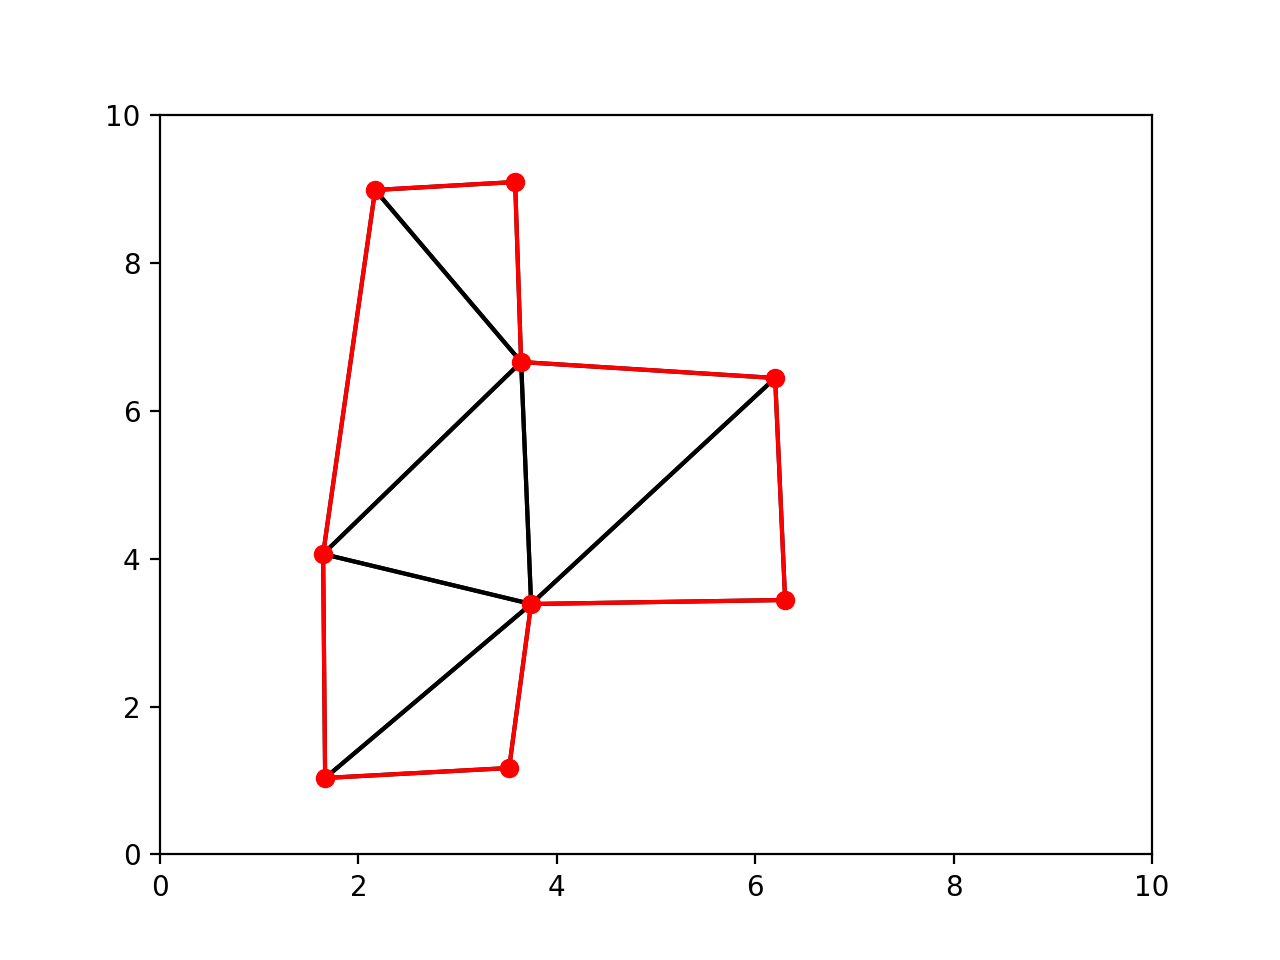

In [10]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.xlim(0, 10)
plt.ylim(0, 10)
polygon = []
plt.ion()
def onclick(event):
    global polygon
    if len(polygon) >= 3 and distance(polygon[0], (event.xdata, event.ydata)) < TOLERANCE:
        plt.plot(*plotPoints(polygon + [polygon[0]]), color='royalblue', marker='o')
        fig.savefig('fig1.png')
        fig.canvas.mpl_disconnect(cid)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        verticesTypes = assignVertices(polygon)
        for i in range(len(polygon)):
            if verticesTypes[i] == 2 or verticesTypes[i] == 3:
                diagonals = findDiagonals(polygon)
                polygons = makeMonotone(polygon, diagonals)
                for subPoly in polygons:
                    if len(subPoly) > 3:
                        triangulate(subPoly)
                return
        triangulate(polygon)

    else:
        polygon.append((event.xdata, event.ydata))
        ax.clear()
        ax.plot(*plotPoints(polygon), marker='o')
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)


cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [11]:
ax.clear()
delanuaya(polygon,0)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_54289/3407025867.py:102: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(hx,hy,'k-',color=c)
/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_54289/1228999399.py:195: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(hx,hy,'k-',color="red")


## Programy bez wizualizacji
### Do sprawdzania szybkości

In [ ]:
def findDiagonalsFast(points):
    verticesTypes = assignVertices(points)
    sortedIndexes = [i for i in range(len(points))]
    maxY = max(sortedIndexes, key=lambda x: points[x][1])
    minY = min(sortedIndexes, key=lambda x: points[x][1])
    
    rightChain = []
    leftChain = []
    i = maxY
    while i != minY:
        rightChain.append(i)
        i = (i - 1) % len(points)
    i = maxY
    while i != minY:     
        i = (i + 1) % len(points)
        leftChain.append(i)
    sortedIndexes = merge(leftChain, rightChain,key=lambda x:points[x][1])  #O(N)
    
    diagonals = []
    bst = BinarySearchTree(points)
    sortedIndexes = sorted([i for i in range(len(points))], key=lambda x: points[x][1], reverse=True)  #do naprawy
    pointersToBST = [[None for _ in range(len(points))] for _ in range(len(points))]
    for i in sortedIndexes:
        broom = ((10, points[i][1]), (0, points[i][1]))
        if verticesTypes[i] == 0:  # 0 - początkowy
            node = Node(((i + 1) % len(points), i), (i, (i - 1) % len(points)))
            bst.broom = broom
            bst.insert(node, points[i][0])
            pointersToBST[i][(i + 1) % len(points)] = node
            pointersToBST[(i + 1) % len(points)][i] = node
            pointersToBST[i][(i - 1) % len(points)] = node
            pointersToBST[(i - 1) % len(points)][i] = node
            node.helper = i
        elif verticesTypes[i] == 1:  # 1 - końcowy
            node = pointersToBST[i][(i - 1) % len(points)]
            if verticesTypes[node.helper] == 2:
                diagonals.append((i, node.helper))
            bst.delete(node)
            pointersToBST[i][(i - 1) % len(points)] = None
            pointersToBST[(i - 1) % len(points)][i] = None
            pointersToBST[i][(i + 1) % len(points)] = None
            pointersToBST[(i + 1) % len(points)][i] = None
        elif verticesTypes[i] == 2:  # 2 - łączący
            node1 = pointersToBST[i][(i-1)%len(points)]
            if verticesTypes[node1.helper] ==2:
                diagonals.append((i,node1.helper))
            pointersToBST[i][(i - 1) % len(points)] = None
            pointersToBST[(i - 1) % len(points)][i] = None
            node2 = pointersToBST[i][(i+1)%len(points)]
            if verticesTypes[node2.helper] ==2:
                diagonals.append((i,node2.helper))
            node2.helper = i
            pointersToBST[node2.rightEdge[0]][node2.rightEdge[1]] = None
            pointersToBST[node2.rightEdge[1]][node2.rightEdge[0]] = None
            node2.rightEdge = node1.rightEdge
            pointersToBST[node2.rightEdge[0]][node2.rightEdge[1]] = node2
            pointersToBST[node2.rightEdge[1]][node2.rightEdge[0]] = node2
            bst.delete(node1)
        elif verticesTypes[i] == 3:  # 3 - dzielący
            bst.broom = broom
            node = bst.findEv(points[i][0])
            diagonals.append((i,node.helper))
            node.helper = i
            newNode = Node((i,(i+1)%len(points)),node.rightEdge)
            newNode.helper = i
            node.rightEdge = (i,(i-1)%len(points))
            bst.insert(newNode,points[i][0])
            pointersToBST[i][(i+1)%len(points)] = newNode
            pointersToBST[(i+1)%len(points)][i] = newNode
            pointersToBST[newNode.rightEdge[0]][newNode.rightEdge[1]] = newNode
            pointersToBST[newNode.rightEdge[1]][newNode.rightEdge[0]] = newNode
            pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = node
            pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = node
        elif verticesTypes[i] == 4:  # 4 - prawidłowy
            if points[i][1] < points[(i-1)%len(points)][1]:
                node = pointersToBST[i][(i-1)%len(points)]
                if verticesTypes[node.helper] == 2:
                    diagonals.append((i,node.helper))
                node.helper = i
                pointersToBST[node.leftEdge[0]][node.leftEdge[1]] = None
                pointersToBST[node.leftEdge[1]][node.leftEdge[0]] = None
                node.leftEdge = (i,(i+1)%len(points))
                pointersToBST[node.leftEdge[0]][node.leftEdge[1]] = node
                pointersToBST[node.leftEdge[1]][node.leftEdge[0]] = node
            else:
                node = pointersToBST[i][(i+1)%len(points)]
                if verticesTypes[node.helper] == 2:
                    diagonals.append((i,node.helper))
                node.helper = i
                pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = None
                pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = None
                node.rightEdge = (i,(i-1)%len(points))
                pointersToBST[node.rightEdge[0]][node.rightEdge[1]] = node
                pointersToBST[node.rightEdge[1]][node.rightEdge[0]] = node

    return diagonals

def triangulateFast(points):
    def nextToEachOther(a, b):
        nonlocal points
        return (abs(a - b) == 1 or {a, b} == {0, len(points) - 1})

    epsilon = 10 ** -10
    sortedIndexes = [i for i in range(len(points))]
    maxY = max(sortedIndexes, key=lambda x: points[x][1])
    minY = min(sortedIndexes, key=lambda x: points[x][1])

    stack = []
    diagonals = []

    rightChain = []
    leftChain = []
    i = maxY
    while i != minY:
        rightChain.append(i)
        i = (i - 1) % len(points)
    i = maxY
    while i != minY:     
        i = (i + 1) % len(points)
        leftChain.append(i)
    sortedIndexes = merge(leftChain, rightChain,key=lambda x:points[x][1])  #O(N)

    stack.append(sortedIndexes[0])
    stack.append(sortedIndexes[1])
    for i in sortedIndexes[2:]:
        if {i, stack[-1]}.issubset(leftChain):
            stack.append(i)
            while len(stack) >= 3 and det3x3(points[stack[-3]], points[stack[-2]], points[stack[-1]]) > epsilon:
                if not nextToEachOther(stack[-3], stack[-1]): diagonals.append((stack[-3], stack[-1]))
                stack.pop(-2)
        elif {i, stack[-1]}.issubset(rightChain):
            stack.append(i)
            while len(stack) >= 3 and det3x3(points[stack[-3]], points[stack[-2]], points[stack[-1]]) < -epsilon:
                if not nextToEachOther(stack[-3], stack[-1]): diagonals.append((stack[-3], stack[-1]))
                stack.pop(-2)
        else:
            stack.pop(0)
            while len(stack) >= 2:
                if not nextToEachOther(stack[0], i):  diagonals.append((stack[0], i))
                stack.pop(0)
            if not nextToEachOther(stack[0], i):  diagonals.append((stack[0], i))
            stack.append(i)

    return diagonals
times =[]
for _ in range(50):
    start = time.time()
    verticesTypes = assignVertices(polygon)
    for i in range(len(polygon)):
        if verticesTypes[i] == 2 or verticesTypes[i] == 3:
            diagonals = findDiagonalsFast(polygon)
            polygons = makeMonotone(polygon, diagonals)
            for subPoly in polygons:
                if len(subPoly) > 3:
                    triangulateFast(subPoly)   
    end = time.time()
    times.append(end - start)
print(sum(times)/50)


In [ ]:
def delanuayaFast(P):
    P = [Point(p[0],p[1]) for p in P]
    triangle_ = supertriangle(P)
    T = set()
    T.add(triangle_)
    for p in P:
        TR = set()
        for t in T:
            if t.in_circumcircle(p):
                TR.add(t)
                t.pt1.remove(t)
                t.pt2.remove(t)
                t.pt3.remove(t)
        polygon = set()
        for t in TR:
            for edge in t.edges:
                isNeighbour = False
                for t_other in TR:
                    if t == t_other:
                        continue
                    for edge_other in t_other.edges:
                        if shared_edge(edge,edge_other):
                            isNeighbour = True
                if not isNeighbour:
                    polygon.add(edge)
                 
        for t in TR:
            T.remove(t)
        for edge in polygon:
            T.add(Triangle(edge.pt1,edge.pt2,p))
    for t in T.copy():
        if t.has_vertex(triangle_.pt1) or t.has_vertex(triangle_.pt2) or t.has_vertex(triangle_.pt3):
            T.remove(t)
    #new
    #getedgestriangulation
    edges_of_triang = set()
    for t in T:
        for edge in t.edges:
            edges_of_triang.add((edge.pt1,edge.pt2))
    
    incident_edges = []
    for i in range(len(P)-1):
        if((P[i],P[i+1]) not in edges_of_triang and (P[i+1],P[i]) not in edges_of_triang):
            incident_edges.append((P[i],P[i+1]))
    
    for edge in incident_edges:
        outer_edge = None
        P1 = edge[0]
        intersected = []
        T1 = None
        E1 = None
        for t in P1.triangles:
            E1 = t.get_outer_edge(P1)
            if(doIntersect(edge[0],edge[1],E1.pt1,E1.pt2)):
                intersected.append(E1)
                T1 = t
                break
        while(True):
            T2 = ((set(E1.pt1.triangles) & set(E1.pt2.triangles)) - set([T1])).pop()
            T2_E = T2.get_outer_point(E1.pt1,E1.pt2)
            if T2_E == edge[0] or T2_E == edge[1]:
                break
            E2 = None
            for e in (T2.edges):
                if(not shared_edge(e,E1)):
                    if(doIntersect(edge[0],edge[1],e.pt1,e.pt2)):
                        E2 = e
                        intersected.append(E2)
                        break
            T1 = T2
            E1 = E2
            
        #swapedges
        while len(intersected) > 0:
            edge_to_swap = intersected.pop(0)
            swap_pt1 = edge_to_swap.pt1
            swap_pt2 = edge_to_swap.pt2
            T1,T2 = (set(swap_pt1.triangles) & set(swap_pt2.triangles))
            T1_P = T1.get_outer_point(swap_pt1,swap_pt2)
            T2_P = T2.get_outer_point(swap_pt1,swap_pt2)
            if orientation(T1_P,T2_P,swap_pt1) is not orientation(T1_P,T2_P,swap_pt2):
                T.remove(T1)
                T.remove(T2)
                swap_pt1.triangles.remove(T1)
                swap_pt1.triangles.remove(T2)
                swap_pt2.triangles.remove(T1)
                swap_pt2.triangles.remove(T2)
                T1_P.triangles.remove(T1)
                T2_P.triangles.remove(T2)
                new_T1 = Triangle(T1_P,swap_pt1,T2_P)
                new_T2 = Triangle(T1_P,swap_pt2,T2_P)
                T.add(new_T1)
                T.add(new_T2)
                if edge[0] != T1_P and edge[0] != T2_P and edge[1] != T1_P and edge[1] != T2_P:
                    if doIntersect(edge[0],edge[1],T1_P,T2_P):
                        intersected.append(new_T1.edges[2])
                
                
            else:
                intersected.append(edge_to_swap)
        #endswapedges
    #endgettingedges
            
    #end_new        
    for t in T.copy():
        pet = [[P.index(t.pt1),t.pt1],[P.index(t.pt2),t.pt2],[P.index(t.pt3),t.pt3]]
        pet.sort()
        if(not orientation(pet[0][1],pet[1][1],pet[2][1])):
            T.remove(t)
times =[]
for _ in range(50):            
    start = time.time()
    delanuayaFast(polygon)    
    end = time.time()
    times.append(end - start)
print(sum(times)/50)
                